In [1]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.postprocess import CmosReflectance, CmosReflectance_ff
from pyeosim.sensor import TeledyneCMOS
from pyeosim.atmosphere import Test6S
from pyeosim.plot import rgb
from pyeosim.measure import NDVI
from sklearn import linear_model

In [2]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000
im_ref = im_ref[:,:100,:100]

In [3]:
atmos = Test6S()
# generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(im_ref))
TOA_10 = atmos.transform(xarray.ones_like(im_ref)*.1)

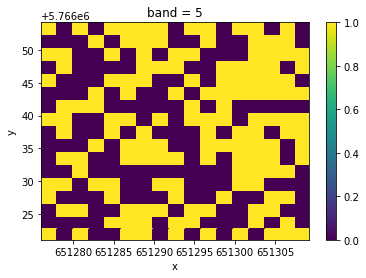

In [74]:
cmos = TeledyneCMOS(sense_node_gain=5,
                    dark_current=5,
                    ccd_vref=3.1,
                    psf_fwhm=2,
                    ground_sample_distance=2,
                    adc_vref=3.1,
                    dark_factor=0.1,
                    offset_factor=0,
                    full_well=1e5,
                    store_steps=True)
cmos.fit(TOA)
cmos.transform(TOA).isel(band=5).plot()

In [78]:
cmos.focal_length

2.5

In [75]:
cmos.get_steps()

['radiant energy to radiant flux',
 'radiant flux at CCD',
 'radiant flux at resampled pixel',
 'radiant flux to flux density',
 'flux to quanta',
 'photon noise',
 'photon to electron',
 'photon FP noise',
 'dark current noise',
 'electron to voltage',
 'column offset noise',
 'voltage to DN']

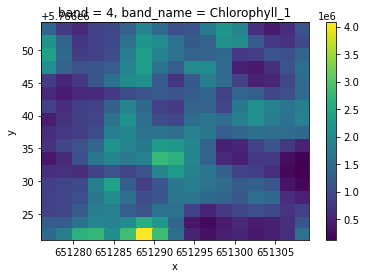

In [76]:
cmos.step_outputs['dark current noise'].isel(band=4).plot()

In [77]:
cmos.step_outputs['dark current noise']

<xarray.DataArray (y: 17, x: 17, band: 10)>
array([[[ 505207., 1334102.,  338273., ..., 1447215., 1163124.,
         1489218.],
        [ 312084.,  787608.,  192262., ...,  758919.,  613050.,
          794455.],
        [ 233996.,  584265.,  136698., ...,  563638.,  475852.,
          719268.],
        ...,
        [ 154645.,  398339.,  172940., ..., 2508319., 2338100.,
         3087039.],
        [ 188609.,  536666.,  272560., ..., 4402328., 4083201.,
         5442942.],
        [ 385458., 1067141.,  350145., ..., 3368599., 3012103.,
         4063727.]],

       [[ 749481., 1997192.,  475805., ..., 1802012., 1386440.,
         1724752.],
        [ 509452., 1329130.,  314184., ..., 1189041.,  925576.,
         1170280.],
        [ 270578.,  689877.,  161501., ...,  688998.,  578178.,
          871759.],
...
        [ 166634.,  439437.,  169027., ..., 2061411., 1884651.,
         2571650.],
        [ 204800.,  575986.,  249344., ..., 3153964., 2906416.,
         3962812.],
        [ 369327., 1069869.,  376352., ..., 3340272., 2994722.,
         4054905.]],

       [[ 453652., 1302209.,  345147., ..., 1433356., 1162009.,
         1590151.],
        [ 590596., 1676032.,  434794., ..., 1727737., 1388300.,
         1862710.],
        [ 811230., 2342019.,  616566., ..., 2527454., 2019190.,
         2696519.],
        ...,
        [ 156001.,  415810.,  182209., ..., 2825147., 2620257.,
         3580443.],
        [ 195590.,  551315.,  255477., ..., 3804098., 3498284.,
         4763232.],
        [ 501727., 1464949.,  481606., ..., 3776791., 3303707.,
         4407823.]]])
Coordinates:
  * y          (y) float64 5.766e+06 5.766e+06 5.766e+06 ... 5.766e+06 5.766e+06
  * x          (x) float64 6.513e+05 6.513e+05 6.513e+05 ... 6.513e+05 6.513e+05
  * band       (band) int64 0 1 2 3 4 5 6 7 8 9
    band_name  (band) <U13 'Clouds' 'Carotenoids' 'PRI_1' ... 'RedEdge_3' 'NIR'

In [81]:
def irradiance_to_flux(irradiance):
    """
    Convert irradiance in W m-2 to photon flux density

    Parameters
    ----------
    ar : xarray.DataArray
        radiance in W m-2
    """
    def _nm_to_m(x):
        """
        Convert nanometer (nm) to metre (m)
        """
        return x * 1e-9
    hc = 1.98644586e-25  # J m
    lambda_ = _nm_to_m(irradiance.wavelength)
    return (lambda_/hc) * irradiance

In [84]:
I = ((((TOA.x[1] - TOA.x[0])**2 * TOA.isel(x=0,y=0))) / 500000**2)

In [90]:
cmos.step_outputs['flux at resampled pixel'] * .001 * 

<xarray.DataArray (y: 34, x: 34, band: 10)>
array([[[ 198395.90864161,  497931.37737575,  130914.27253616, ...,
          629360.501654  ,  572580.06767875, 1089110.61387425],
        [ 175837.49947199,  442070.68546447,  119295.16254714, ...,
          616398.41712795,  569561.69917152, 1088685.70788787],
        [ 131843.96007394,  318956.67375717,   82132.57521773, ...,
          390186.725571  ,  359541.76366718,  688570.94745687],
        ...,
        [ 106402.91966053,  290722.45380481,  130943.84746394, ...,
         1984763.52899779, 2012448.56187982, 3969448.33810476],
        [ 173715.79766085,  461929.14535537,  150508.75650719, ...,
         1496787.60748661, 1475146.14074494, 2943875.95881155],
        [ 220795.88359531,  576729.24000314,  158382.91401845, ...,
         1088923.35538364, 1041688.5594009 , 2095122.12743815]],

       [[ 285278.68238788,  719007.95300443,  173130.52797748, ...,
          721319.74467736,  624787.89912727, 1155690.51754134],
        [ 264553.98514863,  665297.6595319 ,  160864.49157539, ...,
          677718.64180245,  589881.77989598, 1094194.28004896],
        [ 210261.47707979,  519797.13291138,  124100.11034557, ...,
          509599.9063533 ,  443542.61456064,  825137.84018586],
...
        [ 101247.30035774,  275570.47723404,  120588.6202478 , ...,
         1760009.27335458, 1781230.49136275, 3553409.04945591],
        [ 199506.93155566,  554756.189196  ,  187875.73094395, ...,
         1739435.8701458 , 1696987.47273321, 3343772.4829388 ],
        [ 288973.88246106,  808170.94916399,  243894.77980234, ...,
         1610831.75600912, 1521191.36479694, 2964437.53524492]],

       [[ 152188.69040461,  413908.96155441,  108272.70681029, ...,
          481671.98295636,  436181.52577333,  888643.97943335],
        [ 200895.32099613,  551187.18011327,  143641.25162076, ...,
          620306.27394684,  555032.72107946, 1108307.47700501],
        [ 240756.69639313,  656312.26095467,  169029.49065895, ...,
          694945.41233787,  619224.17839748, 1222583.17147551],
        ...,
        [ 105154.78377301,  287730.72893035,  124386.40937507, ...,
         1817935.55431542, 1841058.74730456, 3670356.1953214 ],
        [ 222262.63059818,  622250.44278632,  207034.36672722, ...,
         1813337.18947389, 1760679.65310275, 3462114.08365359],
        [ 332792.4659959 ,  936966.21827165,  279074.71865108, ...,
         1694883.6089207 , 1585193.61972858, 3080398.99962948]]])
Coordinates:
  * y          (y) float64 5.766e+06 5.766e+06 5.766e+06 ... 5.766e+06 5.766e+06
  * x          (x) float64 6.513e+05 6.513e+05 6.513e+05 ... 6.513e+05 6.513e+05
  * band       (band) int64 0 1 2 3 4 5 6 7 8 9
    band_name  (band) <U13 'Clouds' 'Carotenoids' 'PRI_1' ... 'RedEdge_3' 'NIR'

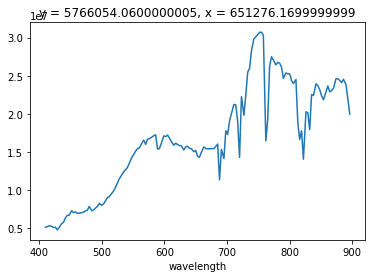

In [86]:
irradiance_to_flux(I).plot()

In [ ]:
hc = 1.98644586e-25  # J m
    lambda_ = _nm_to_m(irradiance.wavelength)
    return (lambda_/hc) * irradiance

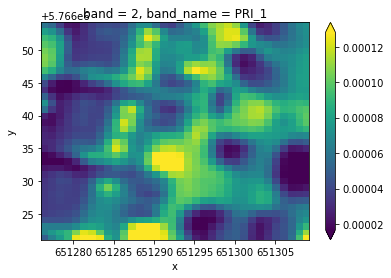

In [62]:
cmos.step_outputs['flux to quanta'].isel(band=2).plot(robust=True)

In [59]:
cmos.Q_E

<xarray.DataArray (band: 10)>
array([0.83, 0.87, 0.88, 0.89, 0.89, 0.9 , 0.88, 0.83, 0.75, 0.51])
Coordinates:
  * band     (band) int64 0 1 2 3 4 5 6 7 8 9

In [41]:
cmos.integration_time

0.09142857142857143

In [15]:
from pyeosim.spectral import TreeView_2, TreeView_1

In [18]:
tv2 = TreeView_2()

In [20]:
len(tv2.srfs)

10

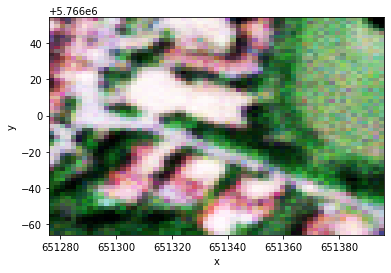

In [5]:
cmos_pipe = CmosReflectance(cmos, TOA_ref)
cmos_pipe.fit(TOA)
ref = cmos_pipe.transform(TOA)
bgr = ref.isel(band=[2,1,0])
rgb(bgr)

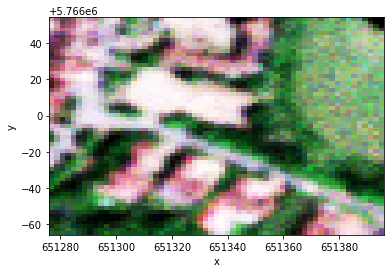

In [6]:
# This version is much slower due to calculation of flat-fielding frames
cmos_pipe = CmosReflectance_ff(cmos, TOA_ref)
cmos_pipe.fit(TOA)
ref = cmos_pipe.transform(TOA)
bgr = ref.isel(band=[2,1,0])
rgb(bgr)

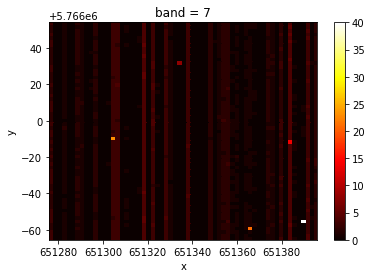

In [7]:
# Generate a sensor dark signal
cmos.transform(xarray.zeros_like(TOA)).isel(band=7).plot(cmap='hot')